In [1]:
from astroquery.vizier import Vizier
from astroquery.sdss import SDSS
import astropy.units as u
from astropy import coordinates as coords
from astropy.table import Table, hstack, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from synphot import SourceSpectrum
from synphot.models import Empirical1D
from synphot import units
import random
import os.path
from collections import Counter
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import snr_derived


In [3]:
# 164 total subclasses, 58 hot star subclasses:
hotClass = [
'A0',
'A0 (19510)',
'A0IVn (25642)',
'A0p',
'A1Iae (12953)',
'A1III (225180)',
'A1m (78209)',
'A1V (95418)',
'A2Ia (14489)',
'A2II (39866)',
'A3Iae (223385)',
'A4 (G_165-39)',
'A4p (G_37-26)',
'A4V (136729)',
'A4V (97603)',
'A5Ia (17378)',
'A5II (34578)',
'A6IV (28527)',
'A8V (155514)',
'A9V (154660)',
'Am (78362)',
'B0.5Iae (185859)',
'B0.5Ibe... (187459)',
'B0IVe (5394)',
'B1Ve (212571)',
'B2.5V (175426)',
'B2.5Ve (187811)',
'B2Iaevar (41117)',
'B2III (35468)',
'B2IV-V (176819)',
'B2Ve (164284)',
'B2Vne (202904)',
'B2Vne (58343)',
'B3Ib/II (51309)',
'B3II (175156)',
'B3V (29763)',
'B3Ve (25940)',
'B5 (338529)',
'B5Ib (191243)',
'B5III (209419)',
'B5V (173087)',
'B6',
'B6IIIpe (109387)',
'B6IV (174959)',
'B7IVe (209409)',
'B8Ib (208501)',
'B8III (220575)',
'B8IV (171301)',
'B9',
'B9 (105262)',
'B9.5V+... (37269)',
'B9III (15318)',
'B9Vn (177756)',
'O',
'O8/O9 (167771)',
'O8e (188001)',
'O9.5Iae (30614)',
'OB'
]


In [10]:
hotStars = Table()
for x in range(len(hotClass)):
    query = "select specobjid, ra, dec, plate, mjd, fiberid, class, subclass, z from specObj where class='STAR' and subclass = '"+hotClass[x]+"'"
    res = SDSS.query_sql(query, data_release=17)
    hotStars = vstack([hotStars, res])


In [13]:
hotStars.write('tables/hotstars.ecsv')


In [4]:
hotStars=Table.read('tables/hotstars.ecsv')


In [15]:
# Pick 1000 random stars
hotStars_1k = hotStars[random.sample(range(len(hotStars)), 1000)]


In [17]:
hotStars_1k.write('tables/hotstars_1k.ecsv')


In [2]:
hotStars_1k=Table.read('tables/hotstars_1k.ecsv')
hotStars_1k


specobjid,ra,dec,plate,mjd,fiberid,class,subclass,z
float64,float64,float64,int32,int32,int32,str4,str19,float64
3.7312441944093245e+18,224.98038,-0.61224314,3314,54970,43,STAR,A0,0.0006146495
6.544868909614651e+18,141.37604,45.611524,5813,56363,46,STAR,A1V (95418),0.0003341742
7.646035853253564e+18,235.33571,56.732179,6791,56429,180,STAR,A2II (39866),-0.0009936119
9.319199541684361e+18,119.06644,43.124837,8277,57073,458,STAR,A4p (G_37-26),0.000177478
6.805186529247648e+18,244.46258,41.939843,6044,56090,900,STAR,A4V (97603),-0.0001727998
7.076336544668473e+18,10.994135,22.565733,6285,56248,202,STAR,A8V (155514),-0.0002458861
2.4871585894965187e+18,248.24663,14.754369,2209,53907,166,STAR,A0,-0.0001720352
6.811749514137065e+18,235.41106,41.823698,6050,56089,200,STAR,A9V (154660),-0.0008251562
3.6445908569309594e+18,196.41757,59.455818,3237,54883,192,STAR,A0,0.0001093311


In [33]:
# Download spectrum files:
import os.path
error = []
for l in range(len(hotStars_1k)):
        plate = hotStars_1k[l]['plate']
        mjd = hotStars_1k[l]['mjd']
        fiber = hotStars_1k[l]['fiberid']
        filename = 'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.fits'
        if not os.path.exists('SDSSspec/'+filename):
            try:
                spec = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber, data_release=17)
                spec[0].writeto('SDSSspec/'+filename)
            except:
                csv_row = str(plate).zfill(4)+', '+str(mjd)+', '+str(fiber).zfill(4)
                error.append(csv_row)

with open('SDSSspec/error.txt', 'w') as f:
    for element in error:
        f.write(element + "\n")


In [ ]:
# Try to "manually" download the spectra that gave error 
from csv import reader
from astroquery.utils import commons as acomm
with open('SDSSspec/error.txt', 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        p, m, f = row[0].strip(), row[1].strip(), row[2].strip()
        filename = 'spec-'+str(p).zfill(4)+'-'+str(m)+'-'+str(f).zfill(4)+'.fits'
        query = "SELECT run2d FROM SpecObjAll WHERE plate="+str(p)+" AND mjd="+str(m)+" AND fiberid="+str(f)
        res = SDSS.query_sql(query, data_release=17)
        r2d = res[0]['run2d']
        link = 'https://data.sdss.org/sas/dr17/sdss/spectro/redux/'+str(r2d)+'/spectra/'+str(p).zfill(4)+'/'+filename
        try:
            spec = acomm.FileContainer(link,encoding='binary',remote_timeout=60,show_progress=True).get_fits()
            spec.writeto('SDSSspec/'+filename)
        except:
            print(link)


In [ ]:
# Execute again the download code to create a new error.txt file

In [49]:
hotStars_1k_final = hotStars_1k
# Remove from table unavailable spectra
from astropy.table import Table, setdiff
with open('SDSSspec/error.txt', 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        a = hotStars_1k_final[hotStars_1k_final["plate"]==int(row[0].strip())]
        b = a[a["mjd"]==int(row[1].strip())]
        c = b[b["fiberid"]==int(row[2].strip())]
        hotStars_1k_final = setdiff(hotStars_1k_final, c, keys=['plate', 'mjd', 'fiberid'])


In [51]:
hotStars_1k_final.write('tables/hotstars_1k_final.ecsv', overwrite=True)


In [3]:
hotStars_1k_final=Table.read('tables/hotstars_1k_final.ecsv')
hotStars_1k_final


specobjid,ra,dec,plate,mjd,fiberid,class,subclass,z
float64,float64,float64,int32,int32,int32,str4,str19,float64
3.1758214174974976e+17,172.68635,-1.0265946,282,51658,285,STAR,A0p,0.004037257
3.288015575774925e+17,192.69223,-0.70316363,292,51609,141,STAR,A0,0.0009300611
3.299505485706957e+17,194.00535,-0.46516802,293,51689,225,STAR,A0,0.0006853736
3.3439697812327014e+17,202.45764,-1.0255067,297,51959,17,STAR,A0,-0.003779948
3.356259571781079e+17,202.44555,0.20447084,298,51955,392,STAR,A0,0.0005138394
3.367337103783629e+17,204.47496,0.63254522,299,51671,326,STAR,A0,-0.0003830112
3.3789947214511514e+17,206.87608,0.39599284,300,51943,471,STAR,OB,-0.004011285
3.390655042095944e+17,210.70818,0.71739591,301,51942,617,STAR,A0,-0.0005463749
3.513030643821056e+17,229.3784,-1.0178533,312,51689,81,STAR,A0,-0.0002606781


In [5]:
# Joint table, with class and subclass, and snr
hotStars_1k_class = Table()
obtyp = Table(names=('sppixmask', 'zwarning', 'good', 'snr'), dtype=('S100', 'S100', 'bool', 'f8'))
for i in range(len(hotStars_1k_final)):
    bitset_m = set()
    bitset_z = set()
    p = hotStars_1k_final[i]['plate']
    m = hotStars_1k_final[i]['mjd']
    f = hotStars_1k_final[i]['fiberid']
    filename = 'spec-'+str(p).zfill(4)+'-'+str(m)+'-'+str(f).zfill(4)+'.fits'
    spec1d = Spectrum1D.read('hotstars_1k/'+filename)
    snrval = snr_derived(spec1d, SpectralRegion(4000*u.AA, 9000*u.AA))
    hdul = fits.open('hotstars_1k/'+filename)
    andmk = hdul[1].data['and_mask']
    zwarn = hdul[2].data['ZWARNING']
    counter = 0
    for v in range(len(zwarn)):
        bits = [bit for bit in range(0, 32) if (zwarn[v] & 1 << bit) > 0]
        if bits!=[]:
            bitset_z.update(bits)
    for v in range(len(andmk)):
        bits = [bit for bit in range(0, 32) if (andmk[v] & 1 << bit) > 0]
        if bits!=[]:
            if bits!=[]: counter=counter+1
            bitset_m.update(bits)
    badpct = counter/len(andmk)
    goodfl = True
    if badpct>0.1:
        goodfl = False
    obtyp.add_row((str(bitset_m), str(bitset_z), goodfl, snrval))
hotStars_1k_class = hstack([hotStars_1k_final, obtyp])


MC1TEMDN=-0.00000000000000E+00 / sp1 mech median temp                            [astropy.io.fits.card]
MC1THT  =-0.00000000000000E+00 / sp1 mech Temp_Hartmann_Top                      [astropy.io.fits.card]
MC1TRCB =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Bot                       [astropy.io.fits.card]
MC1TBCB =-0.00000000000000E+00 / sp1 mech Temp_Blue_Cam_Bot                      [astropy.io.fits.card]
MC1TRCT =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Top                       [astropy.io.fits.card]


In [6]:
hotStars_1k_class.write('tables/hotstars_1k_class.ecsv', overwrite=True)


In [7]:
hotStars_1k_class=Table.read('tables/hotstars_1k_class.ecsv')
hotStars_1k_class


specobjid,ra,dec,plate,mjd,fiberid,class,subclass,z,sppixmask,zwarning,good,snr
float64,float64,float64,int32,int32,int32,str4,str19,float64,str33,str9,bool,float64
3.1758214174974976e+17,172.68635,-1.0265946,282,51658,285,STAR,A0p,0.004037257,"{27, 23}","{0, 2, 3}",True,0.21499054778525192
3.288015575774925e+17,192.69223,-0.70316363,292,51609,141,STAR,A0,0.0009300611,"{26, 23}",set(),True,11.22601111188681
3.299505485706957e+17,194.00535,-0.46516802,293,51689,225,STAR,A0,0.0006853736,"{27, 23}",set(),True,17.312818751503926
3.3439697812327014e+17,202.45764,-1.0255067,297,51959,17,STAR,A0,-0.003779948,"{16, 27, 23}","{0, 2, 3}",True,0.2249877483188382
3.356259571781079e+17,202.44555,0.20447084,298,51955,392,STAR,A0,0.0005138394,{23},set(),True,8.40511395524878
3.367337103783629e+17,204.47496,0.63254522,299,51671,326,STAR,A0,-0.0003830112,{23},set(),True,70.80057919833389
3.3789947214511514e+17,206.87608,0.39599284,300,51943,471,STAR,OB,-0.004011285,"{16, 20, 23}","{0, 2}",True,0.1448772163491223
3.390655042095944e+17,210.70818,0.71739591,301,51942,617,STAR,A0,-0.0005463749,{23},set(),True,12.561142501196196
3.513030643821056e+17,229.3784,-1.0178533,312,51689,81,STAR,A0,-0.0002606781,"{16, 17, 18, 19, 20, 23, 27}",set(),True,35.545191935047505


In [10]:
def plotspecstar(plate, mjd, fiber, direc, title, g, c, save=False):
    filename = 'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.fits'
    hdul = fits.open(direc+filename)
    flux = hdul[1].data['flux']*1e-17*units.FLAM
    loglam = hdul[1].data['loglam']
    wave = 10 ** loglam

    sp = SourceSpectrum(Empirical1D, points=wave, lookup_table=flux, keep_neg=False)
    spu = units.convert_flux(sp.waveset, sp(sp.waveset), units.FLAM)

    plt.figure(figsize=(16,4))
    plt.plot(sp.waveset.value, spu.value)
    plt.xlabel('Wavelength [Ångströms]')
    plt.ylabel('Flux [erg/cm²/s/Å]')
    plt.title(title+' ; '+hdul[2].data['CLASS'][0]+' '+hdul[2].data['SUBCLASS'][0])
    if save==True:
        if g==False:
            folderout='bad/'
        else:
            if c!='STAR':
                folderout='other/'
            else:
                folderout='spec/'
        plt.savefig(folderout+'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.png', facecolor='white', edgecolor='none')
    else:
        plt.show()

def plotspec_star(object, save=False):
    p=object['plate']
    m=object['mjd']
    f=object['fiberid']
    g=object['good']
    c=str(object['class'])
    plotspecstar(p, m, f, 'hotstars_1k/', str(p)+'-'+str(m)+'-'+str(f), g, c, save)


In [11]:
%%capture
# Plot (and save) spectrum loop
for l in range(len(hotStars_1k_class)):
    plotspec_star(hotStars_1k_class[l], save=True)


  points: [5578.2764]
  lookup_table: [-1.11858297e-05] [synphot.models]


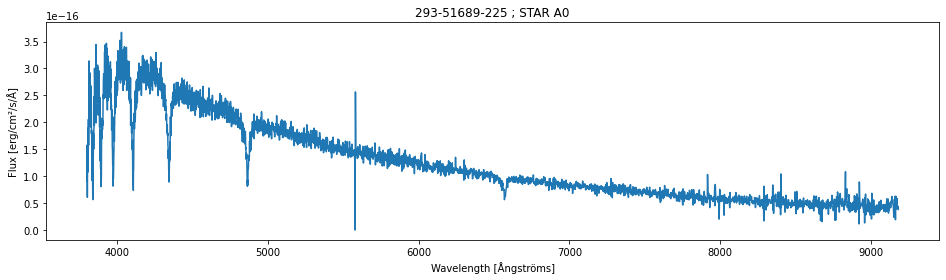

In [9]:
plotspec_star(hotStars_1k_class[2], save=False)
